## The System:

![grafik.png][def]


[def]: .\PTG_System.png

## Preperation
#### Welche Packages brauchen wir NICHT?

In [1]:
#!pip install gurobipy==10.0.0
#!pip install pyomo==6.6.2
#!pip install numpy==1.24.3
#!pip install pandas==1.3.5
#!pip install tsam==2.3.1
#!pip install matplotlib
#!pip install july

In [4]:
from gurobipy import *
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import tsam.timeseriesaggregation as tsam
#import july
#from july.utils import date_range



## Time series
#### Daten laden

In [5]:
data_sheet = pd.read_excel(".\Data_Sheet_neu_2.xlsx")

#data_sheet = data_sheet.iloc[0:7000]
print(data_sheet)

time_slices = np.array(data_sheet.index)
#print(time_slices)



#time_series = list(range(0, 8760))
next_time_slices = {time_slices[i]: time_slices[(i + 1) % len(time_slices)] for i in range(len(time_slices))}
print(next_time_slices)


# gas price of each time slice
power_demand_time_series = dict(zip(time_slices, np.array(data_sheet['PowerD_demand'])))

# heat demand of each time slice
heat_demand_time_series = dict(zip(time_slices, np.array(data_sheet['HeatD_demand'])))

# electricity_price of each time slice
electricity_price_time_series = dict(zip(time_slices, np.array(data_sheet['electricity_price'])))

# PV_Power of eacj time slice
power_PV_time_series = dict(zip(time_slices, np.array(data_sheet['P_PV_tot'])))



      Unnamed: 0  s     t  dt  PowerD_demand  HeatD_demand   P_PV_tot  \
0              0  1     1   1         134.16     88.455029    0.00000   
1              1  1     2   1         131.28     91.817355    0.00000   
2              2  1     3   1         130.56     92.851917    0.00000   
3              3  1     4   1         133.20     87.161827    0.00000   
4              4  1     5   1         133.20     96.214243    0.00000   
...          ... ..   ...  ..            ...           ...        ...   
8755        8755  1  8756   1         127.68    113.801792  114.32600   
8756        8756  1  8757   1         130.56    102.680253  124.98200   
8757        8757  1  8758   1         127.92    102.680253   72.58320   
8758        8758  1  8759   1         128.16     90.006872   53.43440   
8759        8759  1  8760   1         131.52     96.990164   10.01728   

      electricity_price  
0             -0.013287  
1             -0.002750  
2             -0.003778  
3             -0.01

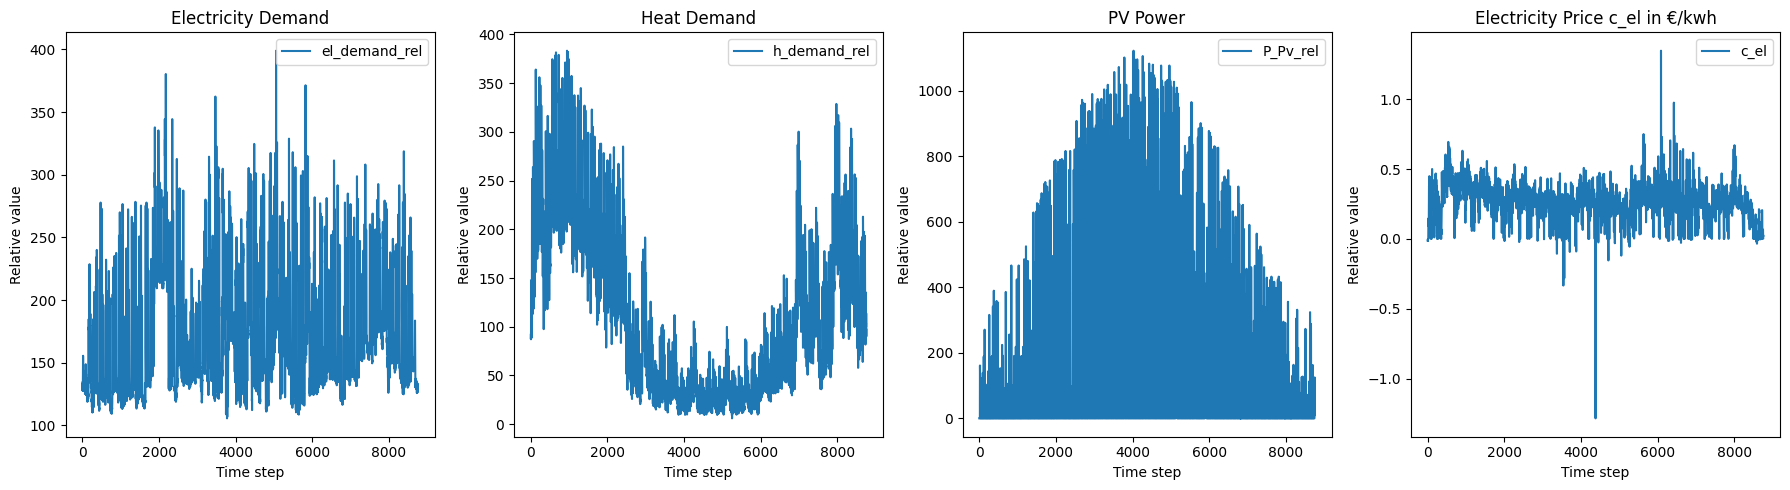

In [6]:
# Erstelle eine Figur mit 3 nebeneinanderliegenden Subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Plot für den ersten Datensatz
axes[0].plot(data_sheet['PowerD_demand'], label='el_demand_rel')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel('Relative value')
axes[0].legend()
axes[0].set_title('Electricity Demand')

# Plot für den zweiten Datensatz
axes[1].plot(data_sheet['HeatD_demand'], label='h_demand_rel')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('Relative value')
axes[1].legend()
axes[1].set_title('Heat Demand')

# Plot für den dritten Datensatz
axes[2].plot(data_sheet['P_PV_tot'], label='P_Pv_rel')
axes[2].set_xlabel('Time step')
axes[2].set_ylabel('Relative value')
axes[2].legend()
axes[2].set_title('PV Power')

# Plot für den dritten Datensatz
axes[3].plot(data_sheet['electricity_price'], label='c_el')
axes[3].set_xlabel('Time step')
axes[3].set_ylabel('Relative value')
axes[3].legend()
axes[3].set_title('Electricity Price c_el in €/kwh')

# Layout anpassen
plt.tight_layout()

# Zeige die Plots
plt.show()


## Setting up the model:

In [4]:
model = ConcreteModel()

# declare sets
model.time_slices = set(time_slices)
#model.next_time_slices = set(next_time_slices)

In [5]:
print(next_time_slices)
print(time_slices)

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 58, 58: 59, 59: 60, 60: 61, 61: 62, 62: 63, 63: 64, 64: 65, 65: 66, 66: 67, 67: 68, 68: 69, 69: 70, 70: 71, 71: 72, 72: 73, 73: 74, 74: 75, 75: 76, 76: 77, 77: 78, 78: 79, 79: 80, 80: 81, 81: 82, 82: 83, 83: 84, 84: 85, 85: 86, 86: 87, 87: 88, 88: 89, 89: 90, 90: 91, 91: 92, 92: 93, 93: 94, 94: 95, 95: 96, 96: 97, 97: 98, 98: 99, 99: 100, 100: 101, 101: 102, 102: 103, 103: 104, 104: 105, 105: 106, 106: 107, 107: 108, 108: 109, 109: 110, 110: 111, 111: 112, 112: 113, 113: 114, 114: 115, 115: 116, 116: 117, 117: 118, 118: 119, 119: 120, 120: 121, 121: 12

In [6]:
# declare decision variables
model.OPEX = Var(domain=NonNegativeReals) # [€]

# declare time dependent decision variables
model.P_e_buy = Var(model.time_slices, domain=NonNegativeReals) # Power, that needs to get bought from the grid [kW_e]
model.P_CH4_sell = Var(model.time_slices, domain=NonNegativeReals) # CH4, that gets to sell to the grid [kW_CH4]
#model.mdot_CO2_atm = Var(model.time_slices, domain=NonNegativeReals) # CH4, that gets to sell to the grid [kW_CH4]

# Component_Inputs
model.P_e_PEM = Var(model.time_slices, domain=NonNegativeReals) # Electrolysis [kW_e]
model.P_e_DAC = Var(model.time_slices, domain=NonNegativeReals) # DirectAirCapture [kW_e]
model.P_H2_MR = Var(model.time_slices, domain=NonNegativeReals) # MethaneReformation [kW_H2]
model.mdot_CO2_MR = Var(model.time_slices, domain=NonNegativeReals) # MethaneReformation [kW_CO2] STIMMT EINHEIT???
model.P_CH4_CHP = Var(model.time_slices, domain=NonNegativeReals) # CombinedHeatPower [kW_CH4]
model.P_CH4_BO = Var(model.time_slices, domain=NonNegativeReals) # Boiler [kW_CH4]

model.y_PEM = Var(model.time_slices, domain=Binary) # Electrolysis, on/off
#model.y_CHP = Var(model.time_slices, domain=Binary) # CombinedHeatPower, on/off
model.y_BO = Var(model.time_slices, domain=Binary) # Boiler, on/off

# Component_Outputs
model.P_e_PV = Var(model.time_slices, domain=NonNegativeReals) # PV [kW_e]
model.P_H2_PEM = Var(model.time_slices, domain=NonNegativeReals) # Electrolysis [kW_H2]
model.mdot_CO2_DAC = Var(model.time_slices, domain=NonNegativeReals) # DirectAirCapture [kg_CO2/hr]
model.P_CH4_MR = Var(model.time_slices, domain=NonNegativeReals) # MethaneReformation [kW_CH4]
model.P_e_CHP = Var(model.time_slices, domain=NonNegativeReals) # CombinedHeatPower [kW_e]
model.P_h_CHP = Var(model.time_slices, domain=NonNegativeReals) # CombinedHeatPower [kW_h]
model.P_h_BO = Var(model.time_slices, domain=NonNegativeReals) # Boiler [kW_h]

# Storages
model.P_e_battery = Var(model.time_slices, domain=Reals) # [negative: storage charge, positive: storage discharge] [kW_e] 
model.P_e_battery_in = Var(model.time_slices, domain=NonNegativeReals) # [kW_e] 
model.P_e_battery_out = Var(model.time_slices, domain=NonNegativeReals) #  [kW_e]
model.storage_level_battery = Var(model.time_slices, domain=NonNegativeReals) # [kWh]
model.in_battery =  Var(model.time_slices, domain=Binary) #einspeichern
model.out_battery = Var(model.time_slices, domain=Binary) #ausspeichern

model.P_h_thermalStorage = Var(model.time_slices, domain=Reals) # [negative: storage charge, positive: storage discharge] [kW_h]
model.P_h_thermalStorage_in = Var(model.time_slices, domain=NonNegativeReals) # [kW_h]
model.P_h_thermalStorage_out = Var(model.time_slices, domain=NonNegativeReals) # [kW_h]
model.storage_level_thermalStorage = Var(model.time_slices, domain=NonNegativeReals) # [kWh]
model.in_thermalStorage =  Var(model.time_slices, domain=Binary) #einspeichern
model.out_thermalStorage = Var(model.time_slices, domain=Binary) #ausspeichern

model.P_H2_gasStorage = Var(model.time_slices, domain=Reals) # [negative: storage charge, positive: storage discharge] [kW_H2]
model.P_H2_gasStorage_in = Var(model.time_slices, domain=NonNegativeReals) # [kW_H2]
model.P_H2_gasStorage_out = Var(model.time_slices, domain=NonNegativeReals) # [kW_H2]
model.storage_level_H2Storage = Var(model.time_slices, domain=NonNegativeReals) # [kWh_H2]
model.in_H2Storage =  Var(model.time_slices, domain=Binary) #einspeichern
model.out_H2Storage = Var(model.time_slices, domain=Binary) #ausspeichern

model.mdot_CO2_gasStorage = Var(model.time_slices, domain=Reals) # [negative: storage charge, positive: storage discharge] [kg_CO2/hr]
model.mdot_CO2_gasStorage_in = Var(model.time_slices, domain=NonNegativeReals) # [kg_CO2/hr]
model.mdot_CO2_gasStorage_out = Var(model.time_slices, domain=NonNegativeReals) # [kg_CO2/hr]
model.storage_level_CO2Storage = Var(model.time_slices, domain=NonNegativeReals) # [kg_CO2]
model.in_CO2Storage =  Var(model.time_slices, domain=Binary) #einspeichern
model.out_CO2Storage = Var(model.time_slices, domain=Binary) #ausspeichern

model.P_CH4_gasStorage = Var(model.time_slices, domain=Reals) # [negative: storage charge, positive: storage discharge] [kW_CH4]
model.P_CH4_gasStorage_in = Var(model.time_slices, domain=NonNegativeReals) # [kW_CH4]
model.P_CH4_gasStorage_out = Var(model.time_slices, domain=NonNegativeReals) # [kW_CH4]
model.storage_level_CH4Storage = Var(model.time_slices, domain=NonNegativeReals) # [kWh_CH4]
model.in_CH4Storage =  Var(model.time_slices, domain=Binary) #einspeichern
model.out_CH4Storage = Var(model.time_slices, domain=Binary) #ausspeichern

In [7]:
# declare parameters

model.price_co2 = 84.4 # [€/ton]
model.price_gas = 0.0775 # [€/kWh]


#model.P_e_N_PV = 900 #[kW_e]
#!!! Muss noch geklärt werden!!

#model.P_e_N_PEM = 900 #[kW_e]
#model.eta_N_PEM = 0.63 #eta muss noch linerarisiert werden!!
#!!model.P_H2_min_PEM = 146.75 #[kW_H2]
#!!model.P_H2_max_PEM = 641.13 #[kW_H2]f
model.P_e_min_PEM = 180 #[kW_e]
model.P_e_max_PEM = 1080 #[kW_e]
#model.p_min_PEM = 0.2
#model.p_max_PEM = 1.2

model.mdot_CO2_N_DAC = 250 #[kg_CO2/hr]
model.eta_DAC = 0.5 #[kg_CO2/kWh_e]

model.P_CH4_N_MR = 1500 #[kW_CH4]
model.eta_MR = 0.78
model.co2need_MR = 0.178 #E_in_CO2/E_out_CH4 [kg_CO2/kWh_CH4]


#model.P_h_N_CHP = 800 #[kW_h]
#model.eta__N_CHP_Q = 0.47 #eta muss noch linerarisiert werden!!
#model.P_h_min_CHP = 56.525 #[kW_h]
#model.P_h_max_CHP = 176.71 #[kW_h]
#model.P_e_min_CHP = 36.8 #[kW_e]
#model.P_e_max_CHP = 128 #[kW_e]
#model.P_CH4_min_CHP = 400 #[kW_CH4]
#model.P_CH4_max_CHP = 800 #[kW_CH4]
#model.eta_N_CHP_P = 0.4 #eta muss noch linerarisiert werden!!
#model.p_min_CHP = 0.5
#model.p_max_CHP = 1

#model.P_h_N_BO = 500 #[kW_h]
#model.eta_N_BO = 0.9 #eta muss noch linerarisiert werden!
model.P_CH4_min_BO = 0.5 #[kW_CH4]
model.P_CH4_max_BO = 500 #[kW_cH4]
#!!model.P_h_min_BO = 0.00164#[kW_h]
#!!model.P_h_max_BO = 450 #[kW_h]
#model.p_min_BO = 0.001
#model.p_max_BO = 1

model.E_N_battery = 5000 #[kWh_e]
model.eta_battery = 0.92 
model.loss_battery = 0.000042 #[1/hr]
model.c_battery = 0.36 #[1/hr]

model.Q_N_thermalStorage = 5000 #[kWh_Q]
model.eta_thermalStorage = 0.95 
model.loss_thermalStorage = 0.005 #[1/hr]
model.c_thermalStorage = 1 #[1/hr]

model.E_N_H2Storage = 5000 #[kWh_H2]
model.m_N_CO2Storage = 5000 #[kg_CO2]
model.E_N_CH4Storage = 5000 #[kWh_CH4]
model.loss_gasTanks = 0 #[1/hr]
model.eta_gasTanks = 1 
model.c_gasTanks = 0.25 #[1/hr]


In [8]:
#declare time dependent parameters
model.P_e_demand = Param(model.time_slices, initialize = power_demand_time_series)
model.Q_demand = Param(model.time_slices, initialize = heat_demand_time_series)

model.electricity_price = Param(model.time_slices, initialize = electricity_price_time_series)

model.P_PV = Param(model.time_slices, initialize = power_PV_time_series)


In [9]:
# declare unindexed constraints
model.OPEX_constraint = Constraint(expr =  model.OPEX == sum(model.electricity_price[time_slice]*model.P_e_buy[time_slice] for time_slice in model.time_slices) 
                                     -  sum(model.price_gas * model.P_CH4_sell[time_slice] for time_slice in model.time_slices))

#+  sum(model.price_co2 * model.mdot_CO2_atm[time_slice] for time_slice in model.time_slices)

# declare rules to setup indexed constraints
def electricty_balance_constraint_rule(model, time_slice):
    return (model.P_e_PV[time_slice] + model.P_e_CHP[time_slice] + model.P_e_battery[time_slice] + model.P_e_buy[time_slice] == model.P_e_demand[time_slice] + model.P_e_PEM[time_slice] + model.P_e_DAC[time_slice])

def heat_balance_constraint_rule(model, time_slice):
    return (model.P_h_CHP[time_slice] + model.P_h_BO[time_slice] + model.P_h_thermalStorage[time_slice] == model.Q_demand[time_slice])

def h2_balance_constraint_rule(model, time_slice):
    return (model.P_H2_PEM[time_slice] + model.P_H2_gasStorage[time_slice] == model.P_H2_MR[time_slice])

def co2_balance_contraint_rule(model, time_slice):
    return (model.mdot_CO2_DAC[time_slice] + model.mdot_CO2_gasStorage[time_slice] == model.mdot_CO2_MR[time_slice])

def ch4_balance_constraint_rule(model, time_slice):
    return (model.P_CH4_MR[time_slice] + model.P_CH4_gasStorage[time_slice] == model.P_CH4_CHP[time_slice] + model.P_CH4_BO[time_slice] + model.P_CH4_sell[time_slice])

##Components, Input->Output, Nenngröße, 
#def PV_constraint_rule(model, time_slice):
#    return model.P_e_PV[time_slice] <= model.P_e_N_PV * model.P_PV[time_slice]
#!!!! passt die Gleichung zu den Inputs? CHecken!!

def PV_constraint_rule(model, time_slice):
    return (model.P_e_PV[time_slice] == model.P_PV[time_slice])

def PEM_constraint_rule(model, time_slice):
    return (model.P_H2_PEM[time_slice] == 47.877 * model.y_PEM[time_slice] + 0.549 * model.P_e_PEM[time_slice])
def PEM_minInput_constraint_rule(model, time_slice):
    return (model.P_e_PEM[time_slice] >= model.P_e_min_PEM * model.y_PEM[time_slice])
def PEM_maxInput_constraint_rule(model, time_slice):
    return (model.P_e_PEM[time_slice] <= model.P_e_max_PEM* model.y_PEM[time_slice])
#def PEM_minOuput_constraint_rule(model, time_slice):
#    return (model.P_H2_PEM[time_slice] >= model.P_H2_min_PEM* model.y_PEM[time_slice]) #ein/aus Variabel hier notwendig?
#def PEM_maxOuput_constraint_rule(model, time_slice):
#    return (model.P_H2_PEM[time_slice] <= model.P_H2_max_PEM* model.y_PEM[time_slice]) #ein/aus Variabel hier notwendig?

def DAC_constraint_rule(model, time_slice):
    return (model.mdot_CO2_DAC[time_slice] == model.eta_DAC * model.P_e_DAC[time_slice])
def DAC_maxOuput_constraint_rule(model, time_slice):
    return (model.mdot_CO2_DAC[time_slice] <= model.mdot_CO2_N_DAC)


def MR_constraint_rule(model, time_slice):
    return (model.P_CH4_MR[time_slice] == model.eta_MR * model.P_H2_MR[time_slice])
def MR_CO2_constraint_rule(model, time_slice):
    return (model.mdot_CO2_MR[time_slice] == model.co2need_MR * model.P_CH4_MR[time_slice])
def MR_maxOuput_constraint_rule(model, time_slice):
    return (model.P_CH4_MR[time_slice] <= model.P_CH4_N_MR)

#hier

#def CHP_heat_constraint_rule(model, time_slice):
#    return model.P_h_CHP[time_slice] == -80.948 * model.y_CHP[time_slice] + 0.317 * model.P_CH4_CHP[time_slice]

def CHP_heat_constraint_rule(model, time_slice):
    return (model.P_h_CHP[time_slice] == 0.47 * model.P_CH4_CHP[time_slice])

#def CHP_heat_minOuput_constraint_rule(model, time_slice):
#    return model.P_h_CHP[time_slice] >= model.P_h_min_CHP * model.y_CHP[time_slice] #ein/aus Variabel hier notwendig?
#def CHP_heat_maxOuput_constraint_rule(model, time_slice):
#    return model.P_h_CHP[time_slice] <= model.P_h_max_CHP * model.y_CHP[time_slice] #ein/aus Variabel hier notwendig?
#def CHP_electricity_constraint_rule(model, time_slice):
#    return model.P_e_CHP[time_slice] == -58.168 * model.y_CHP[time_slice]+ 0.229 * model.P_CH4_CHP[time_slice]
def CHP_electricity_constraint_rule(model, time_slice):
    return (model.P_e_CHP[time_slice] == 0.4 * model.P_CH4_CHP[time_slice])
#def CHP_electricity_minOuput_constraint_rule(model, time_slice):
 #   return model.P_e_CHP[time_slice] >= model.P_e_min_CHP * model.y_CHP[time_slice] #ein/aus Variabel hier notwendig?
#def CHP_electricity_maxOuput_constraint_rule(model, time_slice):
  #  return model.P_e_CHP[time_slice] <= model.P_e_max_CHP * model.y_CHP[time_slice] #ein/aus Variabel hier notwendig?
#def CHP_minInput_constraint_rule(model, time_slice):
   # return model.P_CH4_CHP[time_slice] >= model.P_CH4_min_CHP * model.y_CHP[time_slice]
#def CHP_maxInput_constraint_rule(model, time_slice):
    #return model.P_CH4_CHP[time_slice] <= model.P_CH4_max_CHP * model.y_CHP[time_slice]
def CHP_maxInput_constraint_rule(model, time_slice):
    return (model.P_CH4_CHP[time_slice] <= 1702.12766)
    
    
    
    
def BO_constraint_rule(model, time_slice):
    return (model.P_h_BO[time_slice]  == -26.704 * model.y_BO[time_slice] + 0.955 * model.P_CH4_BO[time_slice])
def BO_minInput_constraint_rule(model, time_slice):
    return (model.P_CH4_BO[time_slice] >= model.P_CH4_min_BO * model.y_BO[time_slice])
def BO_maxInput_constraint_rule(model, time_slice):
    return (model.P_CH4_BO[time_slice] <= model.P_CH4_max_BO * model.y_BO[time_slice])
#def BO_minOuput_constraint_rule(model, time_slice):
 #   return (model.P_h_BO[time_slice] >= model.P_h_min_BO * model.y_BO[time_slice]) #ein/aus Variabel hier notwendig?
#def BO_maxOuput_constraint_rule(model, time_slice):
 #   return (model.P_h_BO[time_slice] <= model.P_h_max_BO * model.y_BO[time_slice]) #ein/aus Variabel hier notwendig?



##Storages, storage_level, storage_maximum

#Battery
def battery_level_constraint_rule(model, time_slice):
    return (model.storage_level_battery[next_time_slices[time_slice]] == 
        model.storage_level_battery[time_slice] * (1-model.loss_battery)
        + (model.P_e_battery_in[time_slice]*model.eta_battery - model.P_e_battery_out[time_slice]/model.eta_battery))
    
def battery_Energy_balance_constraint_rule(model, time_slice):
    return  (model.P_e_battery[time_slice] == -model.P_e_battery_in[time_slice] + model.P_e_battery_out[time_slice])
    
def battery_level_max_in_constraint_rule(model, time_slice):
    return  (model.P_e_battery_in[time_slice] <= model.in_battery[time_slice]*model.c_battery*model.E_N_battery)
    
def battery_level_max_out_constraint_rule(model, time_slice):
    return  (model.P_e_battery_out[time_slice] <= model.out_battery[time_slice]*model.c_battery*model.E_N_battery)

def battery_in_or_out_or_off_constraint_rule(model, time_slice):
    return  (model.in_battery[time_slice] + model.out_battery[time_slice] <= 1)


#thermalStorage
def thermalStorage_level_constraint_rule(model, time_slice):
    return  (model.storage_level_thermalStorage[next_time_slices[time_slice]] == (
        model.storage_level_thermalStorage[time_slice] * (1-model.loss_thermalStorage)
        + (model.P_h_thermalStorage_in[time_slice]*model.eta_thermalStorage - model.P_h_thermalStorage_out[time_slice]/model.eta_thermalStorage)))

def thermalStorage_Energy_balance_constraint_rule(model, time_slice):  
    return  (model.P_h_thermalStorage[time_slice] == - model.P_h_thermalStorage_in[time_slice] + model.P_h_thermalStorage_out[time_slice])  

def thermalStorage_level_max_in_constraint_rule(model, time_slice):        
    return  (model.P_h_thermalStorage_in[time_slice] <= model.in_thermalStorage[time_slice]*model.c_thermalStorage*model.Q_N_thermalStorage)

def thermalStorage_level_max_out_constraint_rule(model, time_slice):    
    return  (model.P_h_thermalStorage_out[time_slice] <= model.out_thermalStorage[time_slice]*model.c_thermalStorage*model.Q_N_thermalStorage)

def thermalStorage_in_or_out_or_off_constraint_rule(model, time_slice):    
    return  (model.in_thermalStorage[time_slice] + model.out_thermalStorage[time_slice] <= 1)


#H2Storage
def H2Storage_level_constraint_rule(model, time_slice):
    return  (model.storage_level_H2Storage[next_time_slices[time_slice]] == (
        model.storage_level_H2Storage[time_slice] * (1-model.loss_gasTanks)
        + (model.P_H2_gasStorage_in[time_slice]*model.eta_gasTanks - model.P_H2_gasStorage_out[time_slice]/model.eta_gasTanks)))   
    
def H2Storage_Energy_balance_constraint_rule(model, time_slice):
    return  (model.P_H2_gasStorage[time_slice] == -model.P_H2_gasStorage_in[time_slice] + model.P_H2_gasStorage_out[time_slice]) 

def H2Storage_level_max_in_constraint_rule(model, time_slice):
    return  (model.P_H2_gasStorage_in[time_slice] <= model.in_H2Storage[time_slice]*model.c_gasTanks*model.E_N_H2Storage)

def H2Storage_level_max_out_constraint_rule(model, time_slice):
    return  (model.P_H2_gasStorage_out[time_slice] <= model.out_H2Storage[time_slice]*model.c_gasTanks*model.E_N_H2Storage)

def H2Storage_in_or_out_or_off_constraint_rule(model, time_slice):
    return  (model.in_H2Storage[time_slice] + model.out_H2Storage[time_slice] <= 1)


#CO2Storage
def CO2Storage_level_constraint_rule(model, time_slice):    
    return  (model.storage_level_CO2Storage[next_time_slices[time_slice]] == (
        model.storage_level_CO2Storage[time_slice] * (1-model.loss_gasTanks)
        + (model.mdot_CO2_gasStorage_in[time_slice]*model.eta_gasTanks - model.mdot_CO2_gasStorage_out[time_slice]/model.eta_gasTanks)))   
    
def CO2Storage_Energy_balance_constraint_rule(model, time_slice):
    return  (model.mdot_CO2_gasStorage[time_slice] == -model.mdot_CO2_gasStorage_in[time_slice] + model.mdot_CO2_gasStorage_out[time_slice])  

def CO2Storage_level_max_in_constraint_rule(model, time_slice):
    return  (model.mdot_CO2_gasStorage_in[time_slice] <= model.in_CO2Storage[time_slice]*model.c_gasTanks*model.m_N_CO2Storage)

def CO2Storage_level_max_out_constraint_rule(model, time_slice):
    return  (model.mdot_CO2_gasStorage_out[time_slice] <= model.out_CO2Storage[time_slice]*model.c_gasTanks*model.m_N_CO2Storage)

def CO2Storage_in_or_out_or_off_constraint_rule(model, time_slice):
    return  (model.in_CO2Storage[time_slice] + model.out_CO2Storage[time_slice] <= 1)


#CH4Storage	
def CH4Storage_level_constraint_rule(model, time_slice):
    return  (model.storage_level_CH4Storage[next_time_slices[time_slice]] == (
        model.storage_level_CH4Storage[time_slice] * (1-model.loss_gasTanks)
        + (model.P_CH4_gasStorage_in[time_slice]*model.eta_gasTanks - model.P_CH4_gasStorage_out[time_slice]/model.eta_gasTanks)))

def CH4Storage_Energy_balance_constraint_rule(model, time_slice):
    return  (model.P_CH4_gasStorage[time_slice] == -model.P_CH4_gasStorage_in[time_slice] + model.P_CH4_gasStorage_out[time_slice])

def CH4Storage_level_max_in_constraint_rule(model, time_slice):
    return  (model.P_CH4_gasStorage_in[time_slice] <= model.in_CH4Storage[time_slice]*model.c_gasTanks*model.E_N_CH4Storage)

def CH4Storage_level_max_out_constraint_rule(model, time_slice):
    return  (model.P_CH4_gasStorage_out[time_slice] <= model.out_CH4Storage[time_slice]*model.c_gasTanks*model.E_N_CH4Storage)

def CH4Storage_in_or_out_or_off_constraint_rule(model, time_slice):
    return  (model.in_CH4Storage[time_slice] + model.out_CH4Storage[time_slice] <= 1)


# declare indexed constraints



model.CH4Storage_level_constraint = Constraint(model.time_slices, rule=CH4Storage_level_constraint_rule)
model.CH4Storage_Energy_balance_constraint = Constraint(model.time_slices, rule=CH4Storage_Energy_balance_constraint_rule)
model.CH4Storage_level_max_in_constraint = Constraint(model.time_slices, rule=CH4Storage_level_max_in_constraint_rule)
model.CH4Storage_level_max_out_constraint = Constraint(model.time_slices, rule=CH4Storage_level_max_out_constraint_rule)
model.CH4Storage_in_or_out_or_off_constraint = Constraint(model.time_slices, rule=CH4Storage_in_or_out_or_off_constraint_rule)

model.Co2Storage_level_constraint = Constraint(model.time_slices, rule=CO2Storage_level_constraint_rule)
model.Co2Storage_Energy_balance_constraint = Constraint(model.time_slices, rule=CO2Storage_Energy_balance_constraint_rule)
model.Co2Storage_level_max_out_constraint = Constraint(model.time_slices, rule=CO2Storage_level_max_out_constraint_rule)
model.Co2Storage_level_max_in_constraint = Constraint(model.time_slices, rule=CO2Storage_level_max_in_constraint_rule)
model.Co2Storage_in_or_out_or_off_constraint = Constraint(model.time_slices, rule=CO2Storage_in_or_out_or_off_constraint_rule)

model.H2Storage_level_constraint = Constraint(model.time_slices, rule=H2Storage_level_constraint_rule)
model.H2Storage_Energy_balance_constraint = Constraint(model.time_slices, rule=H2Storage_Energy_balance_constraint_rule)
model.H2Storage_level_max_out_constraint = Constraint(model.time_slices, rule=H2Storage_level_max_out_constraint_rule)
model.H2Storage_level_max_in_constraint = Constraint(model.time_slices, rule=H2Storage_level_max_in_constraint_rule)
model.H2Storage_in_or_out_or_off_constraint = Constraint(model.time_slices, rule=H2Storage_in_or_out_or_off_constraint_rule)

model.thermalStorage_level_constraint = Constraint(model.time_slices, rule=thermalStorage_level_constraint_rule)
model.thermalStorage_Energy_balance_constraint = Constraint(model.time_slices, rule=thermalStorage_Energy_balance_constraint_rule)
model.thermalStorage_level_max_out_constraint = Constraint(model.time_slices, rule=thermalStorage_level_max_out_constraint_rule)
model.thermalStorage_level_max_in_constraint = Constraint(model.time_slices, rule=thermalStorage_level_max_in_constraint_rule)
model.thermalStorage_in_or_out_or_off_constraint = Constraint(model.time_slices, rule=thermalStorage_in_or_out_or_off_constraint_rule)

model.battery_level_constraint = Constraint(model.time_slices, rule=battery_level_constraint_rule)
model.battery_Energy_balance_constraint = Constraint(model.time_slices, rule=battery_Energy_balance_constraint_rule)
model.battery_level_max_out_constraint = Constraint(model.time_slices, rule=battery_level_max_out_constraint_rule)
model.battery_level_max_in_constraint = Constraint(model.time_slices, rule=battery_level_max_in_constraint_rule)
model.battery_in_or_out_or_off_constraint = Constraint(model.time_slices, rule=battery_in_or_out_or_off_constraint_rule)


model.electricty_balance_constraint = Constraint(model.time_slices, rule=electricty_balance_constraint_rule)
model.heat_balance_constraint = Constraint(model.time_slices, rule=heat_balance_constraint_rule)
model.h2_balance_constraint = Constraint(model.time_slices, rule=h2_balance_constraint_rule)
model.co2_balance_contraint = Constraint(model.time_slices, rule=co2_balance_contraint_rule)
model.ch4_balance_constraint = Constraint(model.time_slices, rule=ch4_balance_constraint_rule)


model.PV_constraint = Constraint(model.time_slices, rule=PV_constraint_rule)
model.PEM_constraint = Constraint(model.time_slices, rule=PEM_constraint_rule)
model.PEM_minInput_constraint = Constraint(model.time_slices, rule=PEM_minInput_constraint_rule)
model.PEM_maxInput_constraint = Constraint(model.time_slices, rule=PEM_maxInput_constraint_rule)
#model.PEM_minOuput_constraint = Constraint(model.time_slices, rule=PEM_minOuput_constraint_rule)
#model.PEM_maxOuput_constraint = Constraint(model.time_slices, rule=PEM_maxOuput_constraint_rule)
model.DAC_constraint = Constraint(model.time_slices, rule=DAC_constraint_rule)
model.DAC_maxOuput_constraint = Constraint(model.time_slices, rule=DAC_maxOuput_constraint_rule)
model.MR_constraint = Constraint(model.time_slices, rule=MR_constraint_rule)
model.MR_CO2_constraint = Constraint(model.time_slices, rule=MR_CO2_constraint_rule)
model.MR_maxOuput_constraint = Constraint(model.time_slices, rule=MR_maxOuput_constraint_rule)
model.CHP_heat_constraint = Constraint(model.time_slices, rule=CHP_heat_constraint_rule)
#model.CHP_heat_minOuput_constraint = Constraint(model.time_slices, rule=CHP_heat_minOuput_constraint_rule)
#model.CHP_heat_maxOuput_constraint = Constraint(model.time_slices, rule=CHP_heat_maxOuput_constraint_rule)
model.CHP_electricity_constraint = Constraint(model.time_slices, rule=CHP_electricity_constraint_rule)
#model.CHP_electricity_minOuput_constraint = Constraint(model.time_slices, rule=CHP_electricity_minOuput_constraint_rule)
#model.CHP_electricity_maxOuput_constraint = Constraint(model.time_slices, rule=CHP_electricity_maxOuput_constraint_rule)
#model.CHP_minInput_constraint = Constraint(model.time_slices, rule=CHP_minInput_constraint_rule)
model.CHP_maxInput_constraint = Constraint(model.time_slices, rule=CHP_maxInput_constraint_rule)
model.BO_constraint = Constraint(model.time_slices, rule=BO_constraint_rule)
model.BO_minInput_constraint = Constraint(model.time_slices, rule=BO_minInput_constraint_rule)
model.BO_maxInput_constraint = Constraint(model.time_slices, rule=BO_maxInput_constraint_rule)
#model.BO_minOuput_constraint = Constraint(model.time_slices, rule=BO_minOuput_constraint_rule)
#model.BO_maxOuput_constraint = Constraint(model.time_slices, rule=BO_maxOuput_constraint_rule)


## Solving the problem

In [10]:
# declare objective
model.total_costs = Objective(expr = model.OPEX,
    sense = minimize)

In [11]:
# Solver
solver = SolverFactory('gurobi')
solver.options['TimeLimit'] = 28800  # Zeitlimit in Sekunden (hier 8 Stunden)
#solver.options['MIPGap'] = 0.01  # Maximale Abweichung von der optimalen Lösung in Prozent
#solver.options['NodeLimit'] = 4000  # Maximale Anzahl an Knoten im Baum, die der Solver durchlaufen soll
#solver.options['IterationLimit'] = 1000  # Maximale Anzahl an Iterationen
#solver.options['MIPGap'] = 0.02  # Beispiel für einen sehr kleinen MIPGap
solver.options['Heuristics'] = 0.5  # Aktiviere Heuristiken zu 80%
#solver.options['Cuts'] = 1  # Aktiviere aggressive Schnitte

# Modell lösen
results = solver.solve(model, tee=True)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-14
Read LP format model from file C:\Users\Raphael\AppData\Local\Temp\tmpo8gik4fg.pyomo.lp
Reading time = 1.42 seconds
x1: 394201 rows, 411721 columns, 1007377 nonzeros
Set parameter TimeLimit to value 28800
Set parameter Heuristics to value 0.5
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 394201 rows, 411721 columns and 1007377 nonzeros
Model fingerprint: 0x33914d8a
Variable types: 306601 continuous, 105120 integer (105120 binary)
Coefficient statistics:
  Matrix range     [3e-05, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 192720 rows and 157704 columns
Presolve time: 2.36s
Presolved: 201481 rows, 2

  91   5.35901382e+03  8.81507431e+03  1.11e-01 1.44e-04  7.73e-02    33s
  92   5.09396445e+03  8.73873664e+03  1.09e-01 1.42e-04  7.61e-02    33s
  93   4.68791298e+03  8.53077181e+03  1.07e-01 1.38e-04  7.41e-02    33s
  94   4.39512319e+03  8.46377682e+03  1.05e-01 1.37e-04  7.33e-02    34s
  95   4.21870469e+03  8.22444638e+03  1.04e-01 1.33e-04  7.16e-02    34s
  96   3.67580149e+03  7.99280601e+03  9.99e-02 1.30e-04  6.97e-02    34s
  97   3.43086824e+03  7.66514055e+03  9.69e-02 1.25e-04  6.68e-02    35s
  98   3.21685667e+03  7.53225796e+03  9.48e-02 1.22e-04  6.56e-02    35s
  99   3.10456404e+03  7.46961540e+03  9.43e-02 1.22e-04  6.52e-02    35s
 100   2.67982990e+03  7.16461826e+03  9.03e-02 1.18e-04  6.31e-02    36s
 101   2.53990167e+03  6.86963104e+03  8.93e-02 1.14e-04  6.12e-02    36s
 102   2.19968835e+03  6.68573634e+03  8.51e-02 1.11e-04  5.95e-02    36s
 103   2.03062102e+03  6.49121113e+03  8.36e-02 1.08e-04  5.81e-02    37s
 104   1.84729433e+03  6.14570200e+03 

In [12]:
print(f"OPEX = {model.OPEX.value} €")

OPEX = 10423.158674407838 €


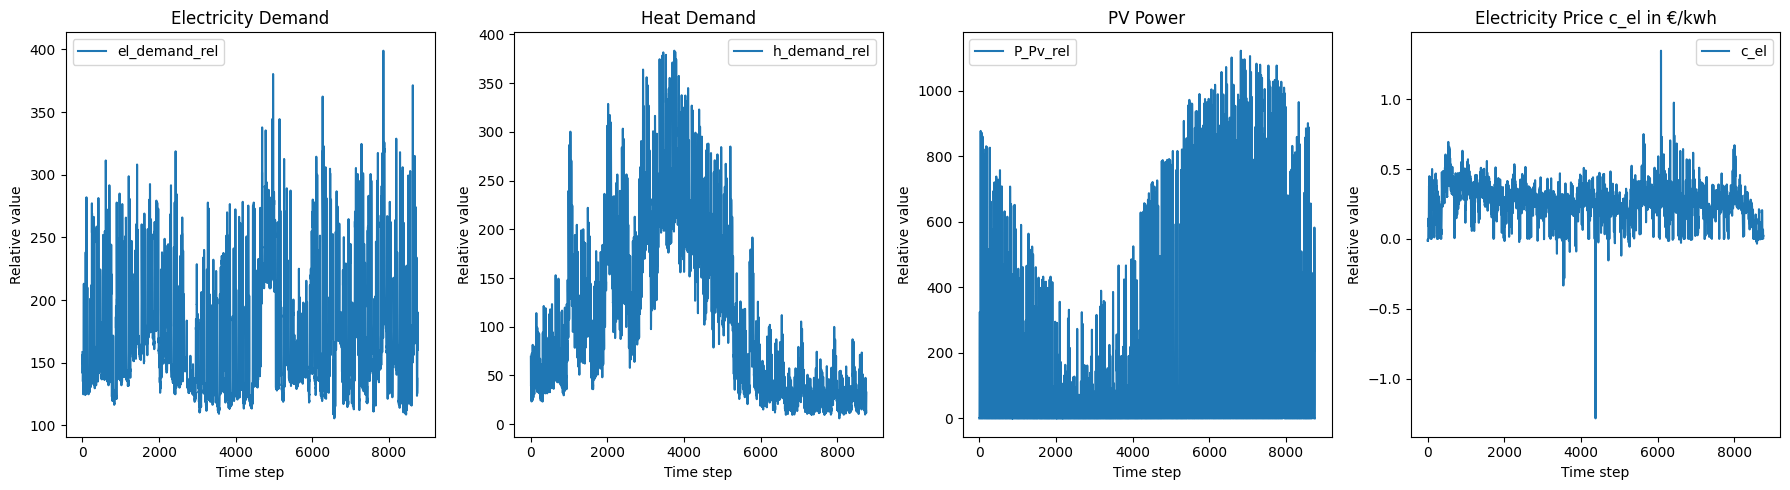

In [1]:
import matplotlib.pyplot as plt

# Liste der Variablennamen, die geplottet werden sollen
variables_to_plot = ['P_e_buy','P_','P_CH4_sell', 'P_e_PV', 'P_e_CHP', 'P_e_battery', 'storage_level_CH4Storage', 'storage_level_thermalStorage', 'storage_level_H2Storage']

# Plotten der Variablen
for var_name in variables_to_plot:
    var_object = getattr(model, var_name)
    time_steps = sorted(var_object.index_set())
    values = [var_object[t].value for t in time_steps]
    
    plt.figure()
    plt.plot(time_steps, values, marker='o')
    plt.xlabel('Time Step')
    plt.ylabel(var_name)
    plt.title(f'{var_name} over Time')
    plt.grid(True)
    plt.show()



NameError: name 'model' is not defined